# Feature Engineering

## Cargue de librerias y parametros

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys
import os

# Agrega la ruta del directorio 'src' al path
sys.path.append(os.path.abspath('../src'))

# Ahora puedes importar tus módulos
from procesamiento_datos import *

Función de procesamiento de datos cargadas correctamente.


In [2]:
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
datos_raw = "..//data/raw/"
datos_processed = "..//data/processed/"

## Cargue de los dataframes

# Pruebas

In [68]:
df_facturas = cargar_datos(datos_raw+'Historico_Facturas.csv')
df_facturas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61393 entries, 0 to 61392
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Nro_factura        61393 non-null  int64  
 1   NIT                61393 non-null  object 
 2   Fecha_expedicion   61393 non-null  object 
 3   Total_factura      61393 non-null  float64
 4   Saldo              61393 non-null  float64
 5   Estado             61393 non-null  object 
 6   Valor_pagado       60598 non-null  float64
 7   Fecha_pago         60598 non-null  object 
 8   Fecha_vencimiento  61393 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 4.2+ MB


In [69]:
convertir_fecha(df_facturas,['Fecha_expedicion','Fecha_pago','Fecha_vencimiento'])
df_facturas['Valor_pagado'] = df_facturas['Valor_pagado'].fillna(0)
df_facturas

,Nro_factura,NIT,Fecha_expedicion,Total_factura,Saldo,Estado,Valor_pagado,Fecha_pago,Fecha_vencimiento
0,186537,42ecd8cb62d29625ad81914f17a48c219acb5d2be2daf0...,2025-06-18,1035398.0,1035398.0,CONFIRMADA,0.0,NaT,2025-07-18
1,177214,46f7f7e4cdea7bc958d0999864222c63474cbd4f9751be...,2024-08-28,773500.0,0.0,PAGADA,773500.0,2024-09-06,2024-09-27
2,161840,727d72342d46d4357539ec474dae79ce388234624a74d7...,2022-11-25,11900000.0,0.0,PAGADA,11900000.0,2022-11-30,2022-12-25
3,161841,c1d637e1f5632d028983dbc5a46b8ea1dcae5a7aee1331...,2022-11-25,11900000.0,0.0,PAGADA,11900000.0,2022-11-30,2022-12-25
4,177216,bec0e3be4b4d494a8b98d121499d2ff4d8bae3cdb5526b...,2024-08-28,773500.0,0.0,PAGADA,773500.0,2024-09-06,2024-09-27
...,...,...,...,...,...,...,...,...,...
61388,181279,97b08d62d4b078cad69cc9a52a325ddf8b88078a21ef0d...,2025-02-13,41562106.0,0.0,PAGADA,41562106.0,2025-02-20,2025-03-15
61389,184044,97b08d62d4b078cad69cc9a52a325ddf8b88078a21ef0d...,2025-03-06,43257302.0,0.0,PAGADA,43257302.0,2025-05-13,2025-04-05
61390,185064,97b08d62d4b078cad69cc9a52a325ddf8b88078a21ef0d...,2025-04-14,45900437.0,0.0,PAGADA,45900437.0,2025-04-21,2025-05-14
61391,185619,97b08d62d4b078cad69cc9a52a325ddf8b88078a21ef0d...,2025-05-09,45269411.0,0.0,PAGADA,45269411.0,2025-06-25,2025-06-08


In [70]:
fecha_referencia = pd.to_datetime('2025-06-30')

df_facturas ['Dias_demora'] = df_facturas.apply(
    lambda row:(row ['Fecha_pago']-row ['Fecha_vencimiento']).days
            if (row ['Estado'] == 'PAGADA' and pd.notna(row['Fecha_pago']))
            else (fecha_referencia - row['Fecha_vencimiento']).days,
    axis = 1
    )

In [71]:
#si los días de mora son negativos o iguales a 30 el habito de pago es bueno = 1 , si son mayores a 30 el habito de pago es malo = 0 
df_facturas['habito_pago'] = df_facturas['Dias_demora'].apply(lambda x: 1 if x <= 30 else 0)
df_facturas['ratio_pago'] =df_facturas['Valor_pagado']/df_facturas['Total_factura']

In [72]:
df_facturas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61393 entries, 0 to 61392
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Nro_factura        61393 non-null  int64         
 1   NIT                61393 non-null  object        
 2   Fecha_expedicion   61393 non-null  datetime64[ns]
 3   Total_factura      61393 non-null  float64       
 4   Saldo              61393 non-null  float64       
 5   Estado             61393 non-null  object        
 6   Valor_pagado       61393 non-null  float64       
 7   Fecha_pago         60598 non-null  datetime64[ns]
 8   Fecha_vencimiento  61393 non-null  datetime64[ns]
 9   Dias_demora        61393 non-null  int64         
 10  habito_pago        61393 non-null  int64         
 11  ratio_pago         61393 non-null  float64       
dtypes: datetime64[ns](3), float64(4), int64(3), object(2)
memory usage: 5.6+ MB


In [75]:
df_facturas_agg = df_facturas.copy()
df_facturas_agg = df_facturas_agg.groupby(['NIT']).agg(
    Total_facturado=('Total_factura','sum'),
    Total_por_pagar = ('Saldo','sum'),
    Total_pagado = ('Valor_pagado','sum'),
    Cantidad_facturas= ('Nro_factura','count'),
    Dias_mora_promedio=('Dias_demora','mean'),
    Porcentaje_pagos_tiempo = ('habito_pago','mean'),
    Promedio_ratio_pago = ('ratio_pago','mean'),
    Desv_dias_demora = ('Dias_demora','std'),
    Maximo_dias_demora = ('Dias_demora','max'),
    Facturas_vencidas = ('Estado',lambda x: (x !="PAGADA").sum())
).reset_index()

df_facturas_agg = df_facturas_agg.round({
    'Dias_mora_promedio':2,
    'Porcentaje_pagos_tiempo':2,
    'Promedio_ratio_pago':2,
    'Desv_dias_demora':2
    })
df_facturas_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2697 entries, 0 to 2696
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NIT                      2697 non-null   object 
 1   Total_facturado          2697 non-null   float64
 2   Total_por_pagar          2697 non-null   float64
 3   Total_pagado             2697 non-null   float64
 4   Cantidad_facturas        2697 non-null   int64  
 5   Dias_mora_promedio       2697 non-null   float64
 6   Porcentaje_pagos_tiempo  2697 non-null   float64
 7   Promedio_ratio_pago      2697 non-null   float64
 8   Desv_dias_demora         1208 non-null   float64
 9   Maximo_dias_demora       2697 non-null   int64  
 10  Facturas_vencidas        2697 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 231.9+ KB


In [77]:
df_facturas_agg['Factura_promedio'] = round(df_facturas_agg['Total_facturado']/df_facturas_agg['Cantidad_facturas'])
df_facturas_agg['Porcentaje_facturas_vencidas'] = round(df_facturas_agg['Facturas_vencidas']/df_facturas_agg['Cantidad_facturas'],2)
df_facturas_agg.head()

,NIT,Total_facturado,Total_por_pagar,Total_pagado,Cantidad_facturas,Dias_mora_promedio,Porcentaje_pagos_tiempo,Promedio_ratio_pago,Desv_dias_demora,Maximo_dias_demora,Facturas_vencidas,Factura_promedio,Porcentaje_facturas_vencidas
0,00019431b6126f9b9bb9bae1c0b02635843eb251e1c887...,2998928.0,0.0,2998928.0,7,-3.29,1.00,1.0,20.38,28,0,428418.0,0.0
1,0018bd0b9cac8d76713b97535738e3004c44cc80821907...,113640820.0,0.0,113640820.0,55,-13.75,1.00,1.0,12.20,24,0,2066197.0,0.0
2,00590f245f22ca6dc9fe272c2e79747bd8da43ff1ab6e3...,783439.0,0.0,783439.0,2,-3.00,1.00,1.0,32.53,20,0,391720.0,0.0
3,007025963bf2a2d6fa88441ff1badad81eaef22e2250b1...,90224784.0,0.0,90224784.0,46,4.17,0.85,1.0,23.58,60,0,1961408.0,0.0
4,0074eeb2e1a555937c7c58c80149c49411855b1b8d7210...,773500.0,0.0,773500.0,1,-24.00,1.00,1.0,NaN,-24,0,773500.0,0.0


## Creación de features

In [90]:
# Crear sistema de scoring
def calcular_score_credito(row):
    score = 0
    
    # 1. Porcentaje de pagos a tiempo (max 30 puntos)
    score += min(row['Porcentaje_pagos_tiempo'] * 30, 30)
    
    # 2. Días de mora promedio (max 25 puntos)
    if row['Dias_mora_promedio'] <= 0:
        score += 25
    elif row['Dias_mora_promedio'] <= 30:
        score += 15
    elif row['Dias_mora_promedio'] <= 60:
        score += 5
    
    # 3. Ratio de pago promedio (max 20 puntos)
    score += min(row['Promedio_ratio_pago'] * 20, 20)
    
    # 4. Facturas vencidas actuales (max 15 puntos)
    if row['Facturas_vencidas'] == 0:
        score += 15
    elif row['Facturas_vencidas'] <= 2:
        score += 7
    
    # 5. Volatilidad en pagos (max 10 puntos)
    if pd.isna(row['Desv_dias_demora']) or row['Desv_dias_demora'] <= 15:
        score += 10
    elif row['Desv_dias_demora'] <= 30:
        score += 5
    
    return score

# Calcular el score para cada cliente
df_facturas_agg['score_credito'] = df_facturas_agg.apply(calcular_score_credito, axis=1)

# Establecer categorías de riesgo basadas en el score
def categorizar_riesgo(score):
    if score >= 85:
        return 'A - Riesgo Bajo'
    elif score >= 70:
        return 'B - Riesgo Moderado Bajo'
    elif score >= 50:
        return 'C - Riesgo Moderado'
    elif score >= 30:
        return 'D - Riesgo Moderado Alto'
    else:
        return 'E - Riesgo Alto'

df_facturas_agg['categoria_riesgo'] = df_facturas_agg['score_credito'].apply(categorizar_riesgo)

# Mostrar distribución de scores y categorías
print("\nDistribución de Scores de Crédito:")
print(df_facturas_agg['score_credito'].describe())

print("\nDistribución de Categorías de Riesgo:")
print(df_facturas_agg['categoria_riesgo'].value_counts())


Distribución de Scores de Crédito:
count    2697.000000
mean       88.681424
std        18.880370
min         9.500000
25%        84.600000
50%       100.000000
75%       100.000000
max       100.000000
Name: score_credito, dtype: float64

Distribución de Categorías de Riesgo:
categoria_riesgo
A - Riesgo Bajo             2017
B - Riesgo Moderado Bajo     257
C - Riesgo Moderado          225
D - Riesgo Moderado Alto     171
E - Riesgo Alto               27
Name: count, dtype: int64


In [98]:
def calificacion (dias_demora):
    if dias_demora >=360:
        return 'E'
    elif dias_demora >= 180:
        return 'D'
    elif dias_demora >= 90:
        return 'C'
    elif dias_demora >= 30:
        return 'B'
    else:
        return 'A'

df_facturas_agg['Calificacion_actual'] = df_facturas_agg['Maximo_dias_demora'].apply(calificacion)

# Mostrar distribución de scores y categorías
print("\nDistribución de Categorías de Riesgo:")
print(df_facturas_agg['Calificacion_actual'].value_counts())


Distribución de Categorías de Riesgo:
Calificacion_actual
A    1855
B     419
C     220
D     103
E     100
Name: count, dtype: int64


## Incorporación de variables macroeconómicas
Agregaremos las variables macroeconómicas (IPC, PIB, tasas de crédito y salario mínimo) al DataFrame final. Estas variables son importantes para capturar el contexto económico en el que se desarrollan los comportamientos de pago.

## Definición de la variable objetivo (Default)
Crearemos la variable objetivo basada en dos criterios:
1. Días de mora > 90 días
2. Calificación crediticia (D o E)

In [91]:
df_final = df_facturas_agg.copy()
# Definir default basado en días de mora y calificación
df_final['default'] = ((df_final['Dias_mora_promedio'] > 90) | 
                      (df_final['categoria_riesgo'].isin(['C','D', 'E']))).astype(int)

# Calcular la tasa de default
tasa_default = df_final['default'].mean() * 100

print(f"Tasa de default en la cartera: {tasa_default:.2f}%")

# Mostrar distribución de defaults por categoría de riesgo
print("\nDistribución de defaults por categoría de riesgo:")
print(pd.crosstab(df_final['categoria_riesgo'], df_final['default'], 
                  normalize='index') * 100)

df_clientes = cargar_datos(datos_raw+"Informacion_Clientes.csv")

df_final = df_final.merge(df_clientes, on= 'NIT',how='left')

# Guardar el DataFrame final procesado
exportar_csv(df_final,datos_processed+"datos_modelado.csv")

Tasa de default en la cartera: 4.93%

Distribución de defaults por categoría de riesgo:
default                            0          1
categoria_riesgo                               
A - Riesgo Bajo           100.000000   0.000000
B - Riesgo Moderado Bajo  100.000000   0.000000
C - Riesgo Moderado        96.444444   3.555556
D - Riesgo Moderado Alto   35.672515  64.327485
E - Riesgo Alto            44.444444  55.555556
Datos exportados exitosamente a ..//data/processed/datos_modelado.csv


In [89]:
df_final

,NIT,Total_facturado,Total_por_pagar,Total_pagado,Cantidad_facturas,Dias_mora_promedio,Porcentaje_pagos_tiempo,Promedio_ratio_pago,Desv_dias_demora,Maximo_dias_demora,...,VAR_Activos_NO_CORRIENTES,VAR_PASIVOS_NO_CORRIENTES,VAR_TOTAL_PASIVOS,PASIVOS_CORRIENTES,VAR_PASIVOS_CORRIENTES,UTILIDAD_NETA,LIQUIDEZ_CORRIENTE,CAPITAL_TRABAJO,ENDEUDAMIENTO,ROA
0,00019431b6126f9b9bb9bae1c0b02635843eb251e1c887...,2998928.0,0.0,2998928.0,7,-3.29,1.00,1.0,20.38,28,...,1.145843,-18.769967,-0.900528,10407888.0,1.018053,-14049.0,1.27,2787696.0,0.55,-0.07
1,0018bd0b9cac8d76713b97535738e3004c44cc80821907...,113640820.0,0.0,113640820.0,55,-13.75,1.00,1.0,12.20,24,...,-27.540656,105.383509,49.703396,54741611.0,36.085837,-4091118.0,1.64,34873515.0,0.74,-4.02
2,00590f245f22ca6dc9fe272c2e79747bd8da43ff1ab6e3...,783439.0,0.0,783439.0,2,-3.00,1.00,1.0,32.53,20,...,-5.832260,283.511847,-82.874431,1415560.0,-83.274561,1946810.0,4.76,5328951.0,0.16,20.85
3,007025963bf2a2d6fa88441ff1badad81eaef22e2250b1...,90224784.0,0.0,90224784.0,46,4.17,0.85,1.0,23.58,60,...,NaN,-88.550619,132.420249,6112169.0,155.140722,9750.0,1.12,747483.0,0.90,0.14
4,0074eeb2e1a555937c7c58c80149c49411855b1b8d7210...,773500.0,0.0,773500.0,1,-24.00,1.00,1.0,NaN,-24,...,-10.000000,NaN,97.154531,8253350.0,97.154531,23749.0,1.18,1510643.0,0.84,0.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,ff0fed0ec7bc5111bb359a15edb5a9a26fbdaaf2458536...,78420027.0,0.0,78420027.0,42,109.62,0.55,1.0,210.87,643,...,2.815248,9.262728,9.966262,1103051.0,12.677525,987841.0,3.30,2539694.0,0.18,3.39
2693,ff2af7e59c68fe36e3f26a57b09c31f5e253c034caf4ec...,595000.0,0.0,595000.0,1,-28.00,1.00,1.0,NaN,-28,...,7.268754,48.867765,-20.337541,422013.0,-31.948315,-436545.0,3.45,1035182.0,0.25,-19.16
2694,ff5e722d76b3a04971c96121480927056670c9e8e837a2...,773500.0,0.0,773500.0,1,-25.00,1.00,1.0,NaN,-25,...,3.155528,-26.587449,-34.372594,8788885.0,-34.400761,-366798.0,1.21,1837058.0,0.80,-3.33
2695,ff77cd42eca6ea173ea6080a3ae568580b632dd946238c...,161200152.0,0.0,161200152.0,39,5.82,0.87,1.0,38.11,141,...,-0.581524,NaN,73.718380,5488660.0,73.718380,488276.0,1.72,3924437.0,0.50,4.41


In [14]:
df_final = cargar_datos(datos_processed+"datos_modelado.csv")
df_final.columns

Index(['NIT', 'Total_facturado', 'Total_por_pagar', 'Total_pagado',
       'Cantidad_facturas', 'Dias_mora_promedio', 'Porcentaje_pagos_tiempo',
       'Promedio_ratio_pago', 'Desv_dias_demora', 'Maximo_dias_demora',
       'Facturas_vencidas', 'Factura_promedio', 'Porcentaje_facturas_vencidas',
       'score_credito', 'categoria_riesgo', 'default', 'PERIODO',
       'FECHA_CORTE', 'ACTIVOS_CORRIENTES', 'GANANCIAS', 'PATRIMONIO',
       'TOTAL_ACTIVOS', 'ACTIVOS_NO_CORRIENTES', 'PASIVOS_NO_CORRIENTES',
       'TOTAL_PASIVOS', 'VAR_ACTIVOS_CORRIENTES', 'VAR_GANANCIAS',
       'VAR_PATRIMONIO', 'VAR_ACTIVOS', 'VAR_Activos_NO_CORRIENTES',
       'VAR_PASIVOS_NO_CORRIENTES', 'VAR_TOTAL_PASIVOS', 'PASIVOS_CORRIENTES',
       'VAR_PASIVOS_CORRIENTES', 'UTILIDAD_NETA', 'LIQUIDEZ_CORRIENTE',
       'CAPITAL_TRABAJO', 'ENDEUDAMIENTO', 'ROA'],
      dtype='object')

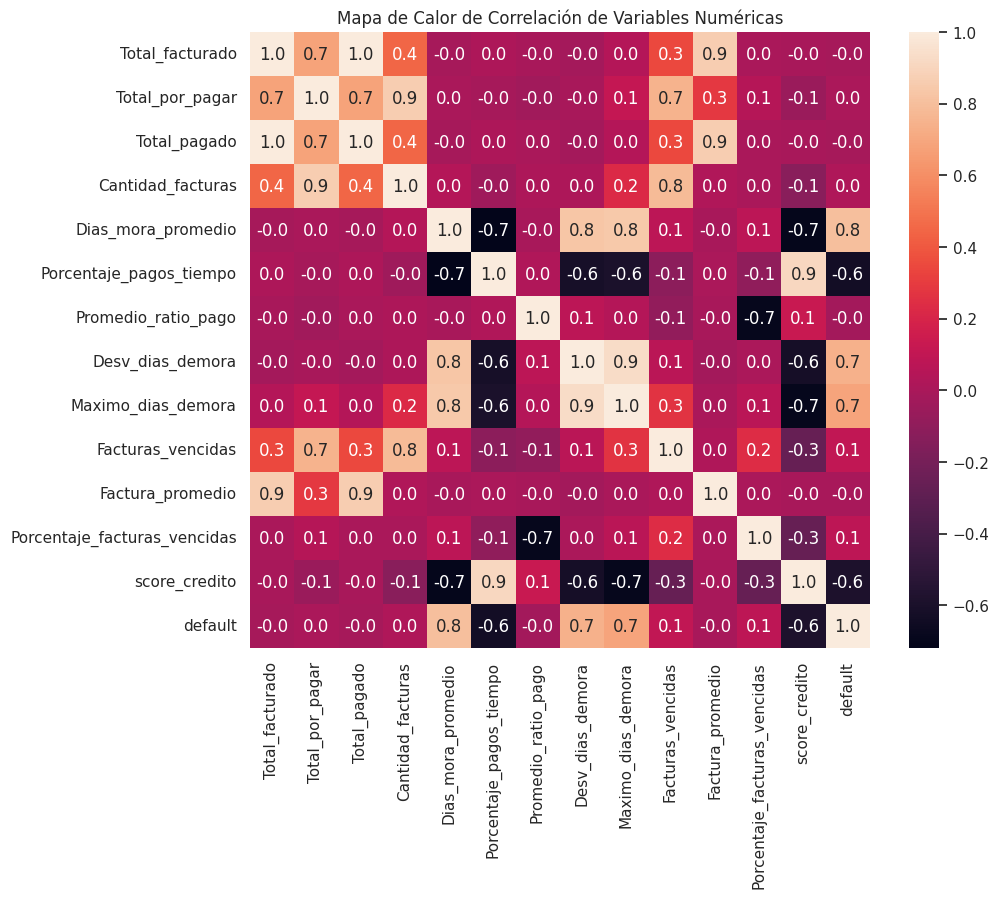

In [21]:
corr = df_final.copy()
columnas = ['Total_facturado', 'Total_por_pagar', 'Total_pagado',
       'Cantidad_facturas', 'Dias_mora_promedio', 'Porcentaje_pagos_tiempo',
       'Promedio_ratio_pago', 'Desv_dias_demora', 'Maximo_dias_demora',
       'Facturas_vencidas', 'Factura_promedio', 'Porcentaje_facturas_vencidas',
       'score_credito', 'default']

corr = corr[columnas]

correlaciones = corr.corr()

plt.figure(figsize=(10, 8)) 
sns.heatmap(data=correlaciones, annot=True, fmt=".1f")
plt.title('Mapa de Calor de Correlación de Variables Numéricas')
plt.show()